define name of the input file

# EN4353 - Radar and Navigation - Assignment 01
#### P.C.G. Mahiepala  - 170368A

define input file name

In [71]:
raw_file = "raw_data2.csv"

In [72]:
!pip  install opencv-python  


### Import libs

In [73]:

import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pylab as plt
import cv2

### show heatmap function

In [74]:
def show_heatmap(image):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(image, linewidth=0,ax=ax,square=False,annot=True,cbar=False,cmap="YlGnBu")
    plt.show()

### open raw file

In [75]:
def readFile(fileName):
    with open(fileName) as f:
        content = f.read().strip().split('\n')
    content = list(map(float, content))
    return content
raw_data1 = readFile(raw_file)
print(raw_data1[:10])

[0.7529806659491659, 0.9963693118913847, 0.15232265110655455, 0.24873368569328708, -0.14089095129824847, 1.2387465662684356, -1.1087847150114285, -0.3593637465167497, -0.09712862713244867, -0.5497736147981629]


### define variables

* Number of samples : $n_{samples} = 18000$
* Raw sampling rate : $F_{s(raw)} = 1080kHz$
* $rpm = 12 rounds per minute$
* Horizontal beam width $\theta_{H} = 2^\circ$
* Pulse rate frequency : $f_{p} = 1800Hz$
* $\sigma = 1$
* Number of range bins : $N = 30$
* $c = 3*10^8$

In [76]:
no_of_samples = 18000
raw_sampling_rate =1080 *10**3
rpm = 12
beam_width =2
prf = 1800
sigma = 1
no_of_range_slots = 30
c = 3*10**8



### calculate other variables

* $F_{s} = N*f_{r}$
* $T_{s} = 1/F_{s}$
* sampling rate (from raw data array) = raw sampling rate / down sampling rate
* number of down samples = number of samples / down sampling rate
* number of beams = number of down samples / number of range bins
* samples per beam = number of range bins * down sampling rate

In [77]:
slot_time = 1/(prf*no_of_range_slots)
down_sampling_rate =1/slot_time
sampling_rate = int(raw_sampling_rate/down_sampling_rate)
no_of_down_samples = no_of_samples/sampling_rate
no_of_beams = int(no_of_down_samples/no_of_range_slots)
samples_per_beam = no_of_range_slots*sampling_rate


### create raw data map

In [78]:
raw_samples_in_beam = []
for i in range(no_of_beams):
    raw_samples_in_beam.append(raw_data1[i*samples_per_beam:(i+1)*samples_per_beam])

print(raw_samples_in_beam[0][:10])
# show_heatmap(raw_samples_in_beam)

[0.7529806659491659, 0.9963693118913847, 0.15232265110655455, 0.24873368569328708, -0.14089095129824847, 1.2387465662684356, -1.1087847150114285, -0.3593637465167497, -0.09712862713244867, -0.5497736147981629]


### Create down sample matrix and mean matrix - Analog to digital conversion

In [79]:
data_matrix =[]
u_matrix =[]
for i in range(no_of_beams):
    data_raw = []
    u_raw = []
    
    for j in range(0,len(raw_samples_in_beam[i]), sampling_rate):
        data_raw.append(raw_samples_in_beam[i][j])
        l = max(0, j-20)
        r= min(len(raw_samples_in_beam[i]), j+21)
        lg = max(0, j-2)
        rg = min(len(raw_samples_in_beam[i]), j+3)
        u = np.mean(raw_samples_in_beam[i][l:lg] + raw_samples_in_beam[i][rg:r])
        u_raw.append(u)
    data_matrix.append(data_raw)
    u_matrix.append(u_raw)

data_matrix = np.array(data_matrix)
u_matrix = np.array(u_matrix)
    
        

### Data matrix before thesholding

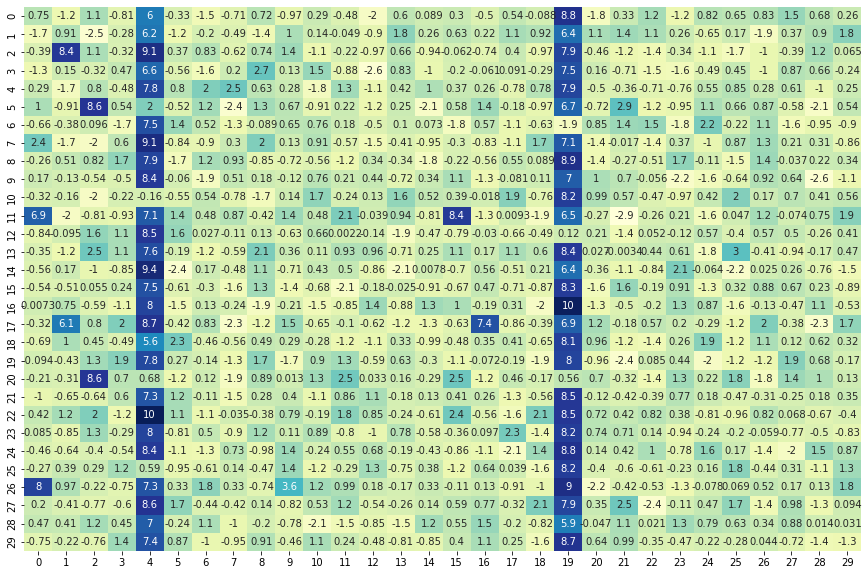

In [80]:

show_heatmap(data_matrix)

### data matrix after thesholding

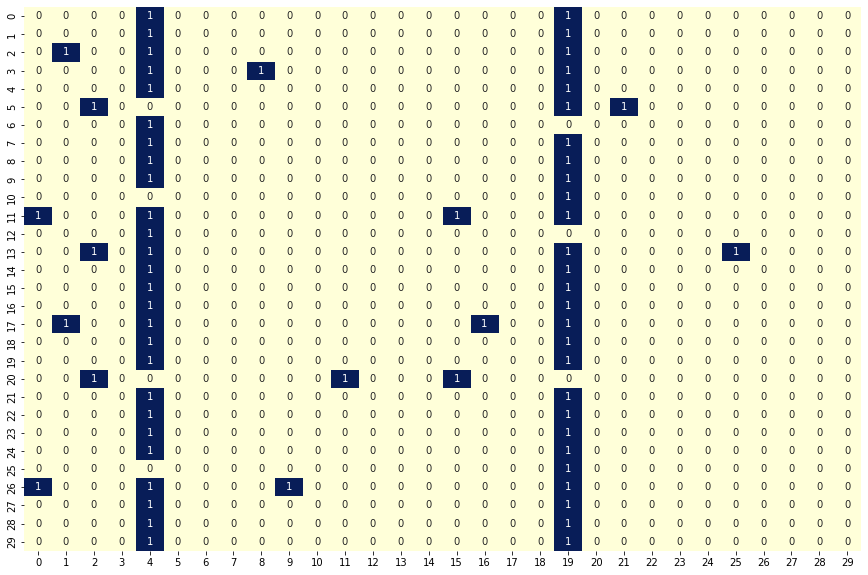

In [81]:
k = 2.5
binary_matrix = np.array([[1.0 if data_matrix[i][j] > u_matrix[i][j]  + k else 0.0 for j in range(len(data_matrix[i]))] for i in range(len(data_matrix))])
show_heatmap(binary_matrix)



### Find targets and remove them for identifying clouds

[False False False False  True False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]


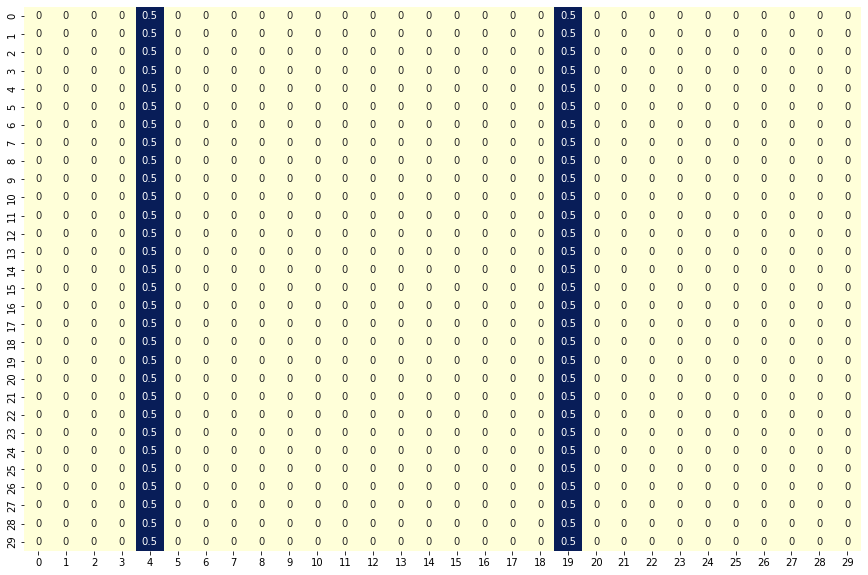

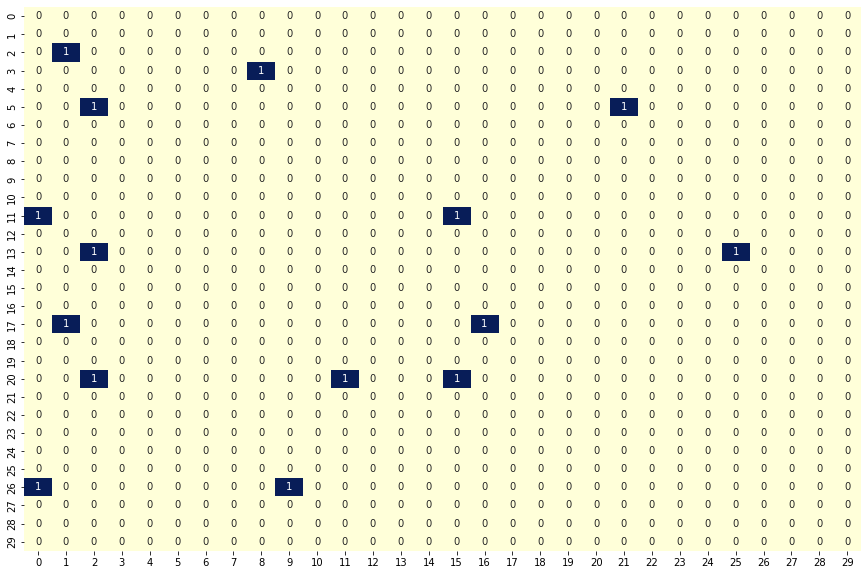

In [82]:
#find targets
target_matrix  = np.sum(binary_matrix, axis=0)
target_matrix = target_matrix>15 #check if atlest 50% of the samples are 1
for i in range(len(binary_matrix)):
    binary_matrix = binary_matrix * (1-target_matrix)

targetMatrix = np.zeros(binary_matrix.shape)  + target_matrix *0.5
print(target_matrix)
show_heatmap(targetMatrix)

show_heatmap(binary_matrix)




### Remove outlires

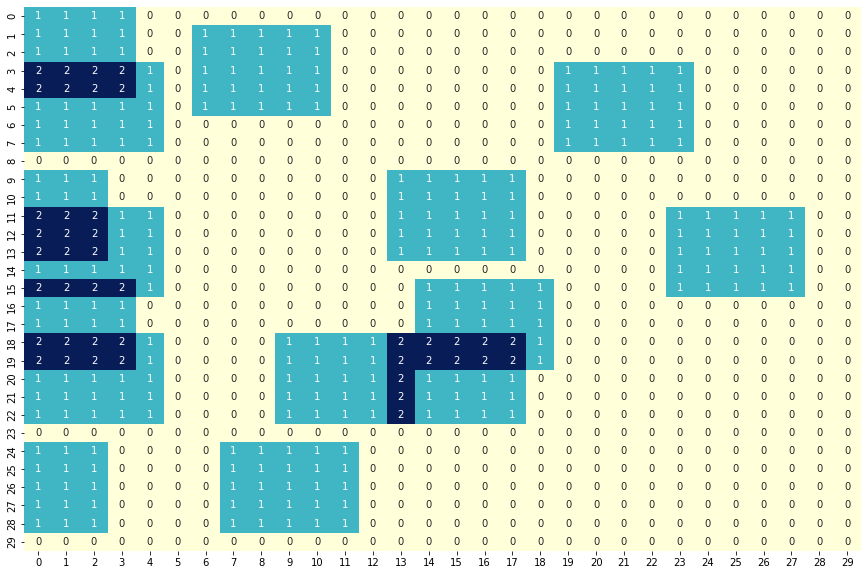

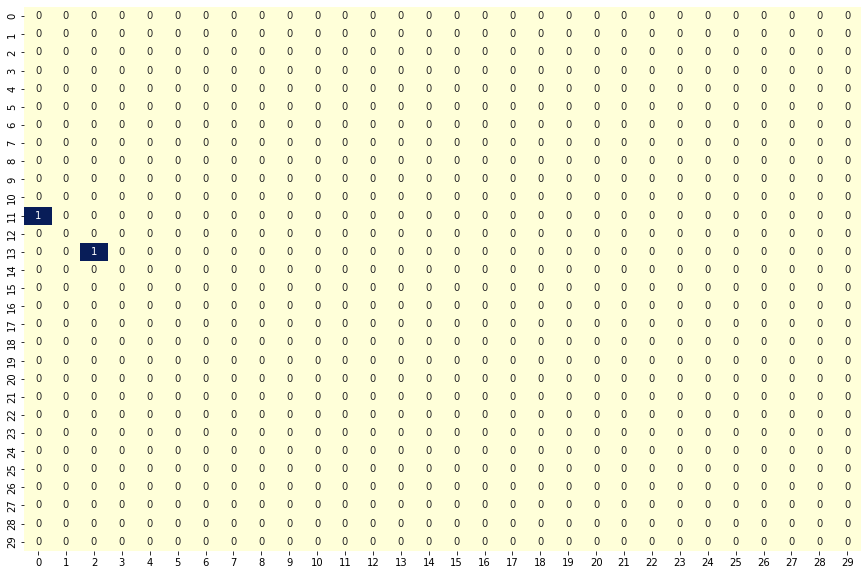

In [83]:
#remove outlires
kernal = np.ones((5,5))

mask  = cv2.filter2D(binary_matrix, -1, kernal, borderType=cv2.BORDER_CONSTANT) # create a mask to remove outliers
show_heatmap(mask)
mask_binary = np.array([[1.0 if mask[i][j] > 1 else 0.0 for j in range(len(mask[i]))] for i in range(len(mask))])
masked_binary_matrix = binary_matrix * mask_binary

show_heatmap(masked_binary_matrix)


### Join two dots that are one/two cells apart

In [84]:
def fill_two_space(patch):
  kernel = patch[:]
  for i in range (4):
      if  (kernel[i,0] ==1 and kernel[i,3]==1) : 
    
        kernel[i,1:3] = 4 
      elif (i<3) and (kernel[i,0] ==1 and kernel[i+1,3]==1) :
     
        kernel[i,1] = 5
        kernel[i+1,2]=5
      elif (i<2) and (kernel[i,0] ==1 and kernel[i+2,3]==1) :
        
        kernel[i+1,1] = 6
        kernel[i+2,2]=6
      elif (i<1) and (kernel[i,0] ==1 and kernel[i+3,3]==1) :
       
        kernel[i+1,1] = 7
        kernel[i+2,2]=7

  return kernel 

def draw_lines2 (image):
  h,w = image.shape
  kernel_offset = 3
  for i in range (0,h-kernel_offset):
    for j in range (0,w- kernel_offset):
      kernel = image[i:i+kernel_offset+1,j:j+kernel_offset+1]

      kernal1 = fill_two_space(kernel)
      kernal2 =  np.flip(fill_two_space(np.flip(kernal1,axis=1)),axis=1)
      kernal3 =  np.transpose(fill_two_space(np.transpose(kernal2)))
      image[i:i+kernel_offset+1,j:j+kernel_offset+1] = kernal3
  return image


In [85]:
def fill_space1(patch):
  if(patch[0,0] == 1):
    if(patch[0,2] == 1):
      patch[0,1] = 2
    elif(patch[2,2] == 1 or patch[1,2] == 1):
      patch[1,1] = 2
  return patch
    
def draw_line_1(pre_img):
  h,w = pre_img.shape
  kernel_offset = 3
  for i in range (0,h-kernel_offset):
    for j in range (0,w-kernel_offset):
      kernel1 = pre_img[i:i+kernel_offset,j:j+kernel_offset]
      patch = fill_space1(kernel1)
      patch2 = np.flip( fill_space1(np.flip(patch,axis=1)),axis=1)
      patch3 = np.transpose(fill_space1(np.transpose(patch2)))
      patch4 = np.rot90(fill_space1(np.rot90(patch3)), k = 3)
      patch5 = np.flip( fill_space1(np.flip(patch4,axis=0)),axis=0)
      pre_img[i:i+kernel_offset,j:j+kernel_offset] = patch5

  return pre_img

# Join dots and create clouds

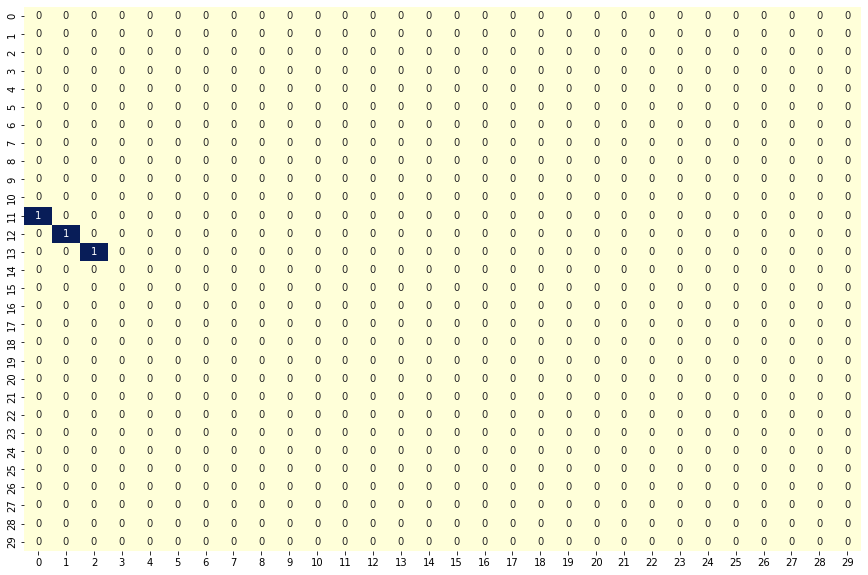

In [86]:
m = masked_binary_matrix.copy()
gap2_filled = draw_lines2(m)
gap1_filled = (draw_line_1(gap2_filled) > 0 ) *1

show_heatmap(gap1_filled)


# Fill inside of clouds   

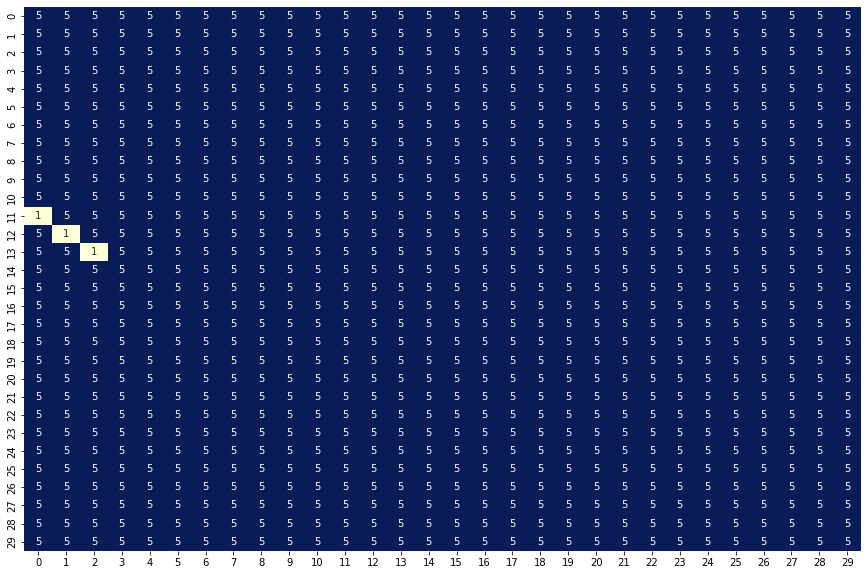

In [87]:
gap1_filled = gap1_filled.astype('uint8')
ff=cv2.floodFill(gap1_filled, None, seedPoint=(0,0), newVal=5)
ff = ff[1].reshape(ff[1].shape[0],ff[1].shape[1])
show_heatmap(ff)

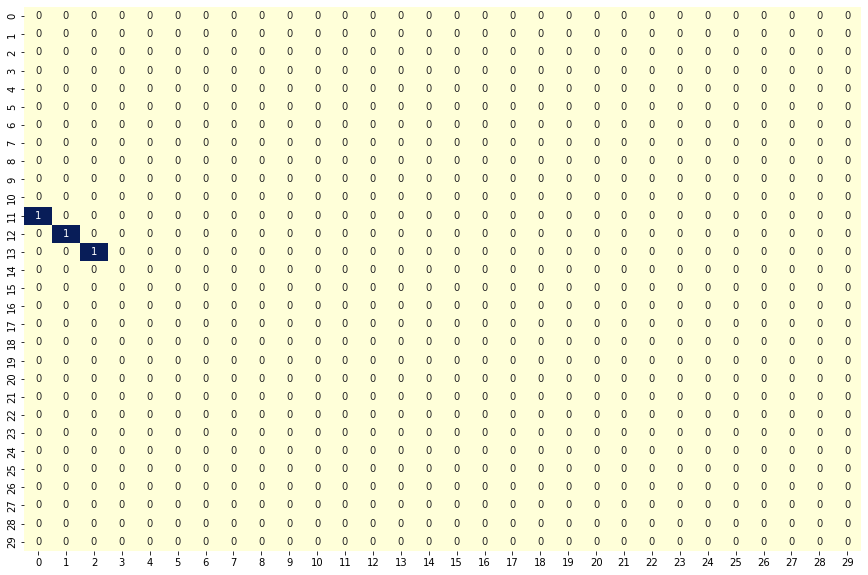

In [88]:
binary_matrix = (ff<4)*1
show_heatmap(binary_matrix)

### Remove remaining outlires

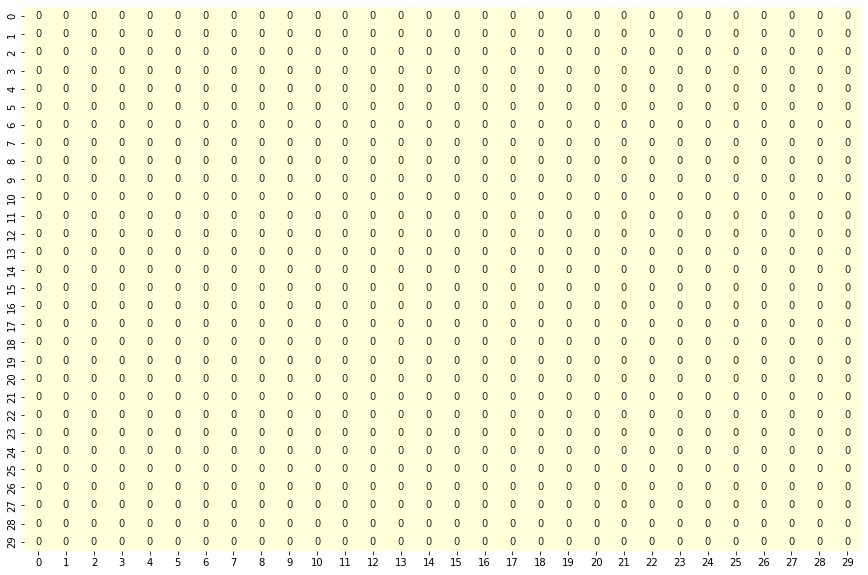

In [89]:
#remove outlires
kernal = np.ones((3,3))
binary_matrix = binary_matrix.astype('uint8')
cloud_mask  = cv2.filter2D(binary_matrix, -1, kernal, borderType=cv2.BORDER_CONSTANT)
cloud_mask_binary = np.array([[1 if cloud_mask[i][j] > 4 else 0.0 for j in range(len(cloud_mask[i]))] for i in range(len(cloud_mask))])
cloud_binary_matrix = binary_matrix * cloud_mask_binary
show_heatmap(cloud_binary_matrix)

### Add targets to final map

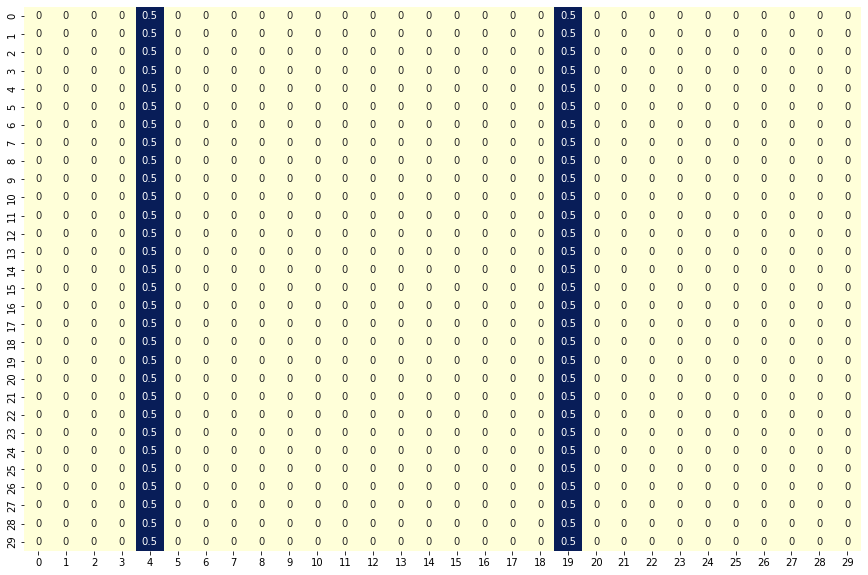

In [90]:
target_matrix = target_matrix * 1
cloud_binary_matrix_with_targets = cloud_binary_matrix  + target_matrix *0.5
show_heatmap(cloud_binary_matrix_with_targets)

### range and azimuth angle calculation

asuming azimuth angle = 0 (The beam width is 2 degrees. Number of raw radar samples are 18000 and rotaion speed is 12 rounds per minute hence the angle that the radar is scanning is less than 2 degrees)
* $\theta_{revolved} = \frac{roatation\ speed\ \times T_{sample}\ 360^\circ} {60} = 1.2^\circ$

Hence the number of samples given is not enough to detect the aziimuth angle.

In [91]:
def calculate_range_and_azimuth_angle(target_matrix):
    length_of_a_bin = c * slot_time / 2
    data = []
    for i in range(len(target_matrix)):
        if(target_matrix[i] == 1):
            range_ = (i+1) * length_of_a_bin
            azimuth_angle = 0
            d = {
                'range': range_,
                'azimuth_angle': azimuth_angle
            }
            data.append(d)
    return data
    


In [92]:
data = calculate_range_and_azimuth_angle(target_matrix)
for i in range(len(data)):
    print("range: ", " {range:.2f} km".format(range = data[i]['range']), " azimuth_angle: {az}".format(az =data[i]['azimuth_angle']))

range:   13888.89 km  azimuth_angle: 0
range:   55555.56 km  azimuth_angle: 0
